# Detecting SQL injections using BERT 

**Install nedded libraries**

In [ ]:
# !pip install ktrain 
# !pip install chardet

**Importing the libraries**

In [1]:
import numpy as np
import ktrain
from ktrain import text
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle

**Reading and displaying the dataset**

In [23]:
# Detect the encoding of the CSV file
with open('SQLiV3_4.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Read the CSV file into a pandas dataframe, using the detected encoding
# df = pd.read_csv('sqliv2.csv', sep=',',  encoding=result['encoding']).sample(n=250)
df = pd.read_csv('SQLiV3_4.csv', sep=',',  encoding=result['encoding'])

# Display the first rows of the dataframe
print(df.head(10))

                                            Sentence  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1   AND 1  =  utl_inaddr.get_host_address   (    ...      1
2   select * from users where id  =  '1' or @ @1 ...      1
3   select * from users where id  =  1 or 1#"  ( ...      1
4   select name from syscolumns where id   =     ...      1
5  select * from users where id  =  1 +$+ or 1  =...      1
6  1;  (  load_file  (  char  (  47,101,116,99,47...      1
7   select * from users where id  =  '1' or ||/1 ...      1
8   select * from users where id  =  '1' or \.<\ ...      1
9                                    ? or 1  =  1 --      1


In [24]:
df.shape

(27605, 2)

In [25]:
print("----------------------------------------------------")
df.info()
print("----------------------------------------------------")

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27605 entries, 0 to 27604
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  27605 non-null  object
 1   Label     27605 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 431.5+ KB
----------------------------------------------------


In [26]:
df['Label'].describe()


count    27605.000000
mean         0.409274
std          0.491709
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64

**Process NaN values**

In [27]:
# Count NaN label values.
df['Label'].isna().sum() 


0

**the target label**

In [28]:
# Get unique values existing in the label column.

unique_label = pd.unique(df['Label'])

print(unique_label)

[1 0]


In [29]:
# Count how much label are 1.
df[df['Label'] == 1].count() 


Sentence    11298
Label       11298
dtype: int64

In [30]:
# Count how much label are 0.
df[df['Label'] == 0].count() 


Sentence    16307
Label       16307
dtype: int64

**Distribution of the label**

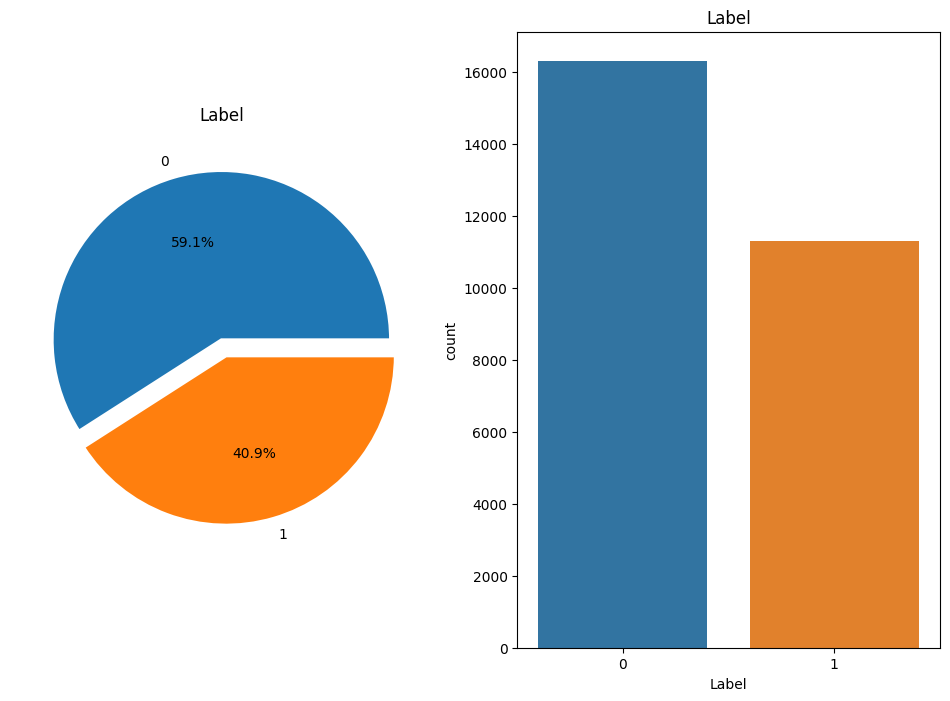

In [31]:
# Distribution of the label

import matplotlib.colors as mcolors
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
df['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=df, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

**Creating the training and test sets**

In [12]:
sentences = df['Sentence'].tolist()
labels = df['Label'].tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=1500)

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(sentences_train, labels_train, 
                                                                       preprocess_mode='bert',
                                                                       maxlen=500,
                                                                      class_names=list(set(labels_train))
                                                                      )

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


# Building the BERT model

In [14]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 500


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


# Training the BERT model

In [15]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [16]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
2712/2712 [==============================] - 184s 58ms/step - loss: 1.7540 - accuracy: 0.6912


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


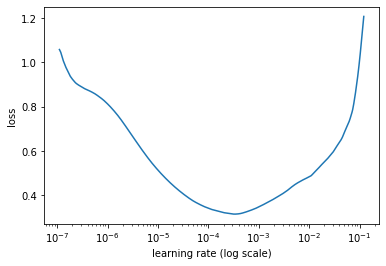

In [17]:
learner.lr_plot()

In [18]:
learner.fit_onecycle(lr=2e-5, epochs=4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
2712/2712 [==============================] - 342s 119ms/step - loss: 0.0301 - accuracy: 0.9897 - val_loss: 0.0061 - val_accuracy: 0.9972
Epoch 2/4
2712/2712 [==============================] - 317s 117ms/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 3/4
2712/2712 [==============================] - 317s 117ms/step - loss: 2.8025e-04 - accuracy: 0.9999 - val_loss: 0.0020 - val_accuracy: 0.9994
Epoch 4/4
2712/2712 [==============================] - 317s 117ms/step - loss: 6.5042e-06 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9994


In [19]:
learner.validate(class_names=preproc.get_classes())


57/57 [==============================] - 13s 151ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       928
           1       1.00      1.00      1.00       880

    accuracy                           1.00      1808
   macro avg       1.00      1.00      1.00      1808
weighted avg       1.00      1.00      1.00      1808



array([[927,   1],
       [  0, 880]])

**Inspecting Misclassifications**

In [20]:
learner.view_top_losses(n=30, preproc=preproc)

57/57 [==============================] - 9s 151ms/step
----------
id:263 | loss:3.97 | true:0 | pred:1)

[CLS] create table if not exists ` z ##c ##f _ submit ##log ##s ` ( ` id ` int ( 6 ) unsigned not null auto _ inc ##rem ##ent , ` cr ##ms ##ub ##mit ##log ##sta ##tus ` var ##cha ##r ( 20 ) default null , ` cr ##ms ##ub ##mit ##log ##des ##cr ##ib ##tion ` long ##text not null , ` cr ##ms ##ub ##mit ##form ##type ` var ##cha ##r ( 30 ) not null , primary key ( id ) ) engine = inn ##od ##b default char ##set = ut ##f ##8 [SEP]


In [42]:
predictor = ktrain.get_predictor(learner.model, preproc)

# make predictions 
samples = [
     "1'; DROP TABLE users;--;",
     "INSERT INTO users (username, password) VALUES ('testuser', 'testpassword'); DROP TABLE users;",
     "SELECT COUNT(*) FROM users WHERE username = 'admin' OR 1 = 1",
     "UPDATE users SET password = 'newpassword' WHERE username = 'admin';" ,
     "select * from generate_series  (  5980,5980,case when   (  5980  =  5063  )   then 1 else 0 end  )   limit 1--",
     "SELECT TOP 3 * FROM growth SELECT * FROM catch 3SELECT * FROM mainly",
     "SELECT * FROM users WHERE username = '' OR 1:1",
     "INSERT INTO column ( white, does, certain, curious, first, our )  VALUES  ( 'rose', 'anyone'. close', 'remove', 'force', 'feet', 'fell' )",
     "SELECT * FROM users WHERE username = '' OR 1=2 --' AND password = 'input_password'"]
prediction = predictor.predict(samples)
print(prediction)

1/1 [==============================] - 0s 74ms/step
[1, 0, 1, 0, 1, 0, 1, 0, 1]


# Save Trained Model

In [ ]:
with open('final_model.pkl', 'wb') as f:
    pickle.dump(predictor, f)

# Load Trained Model

In [ ]:
# # Load the saved model from file
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

# # Use the loaded model
# model.predict(...)